## Readings

* [200 COP in MI: Exploring Polysemanticity and Superposition](https://www.alignmentforum.org/posts/o6ptPu7arZrqRCxyz/200-cop-in-mi-exploring-polysemanticity-and-superposition)
* Neel Nanda's [Dynalist notes on superposition](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2)
* Anthropic's [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html)

# Understanding Superposition and Privileged Bases

When working with neural networks, we often encounter two important concepts: privileged bases and superposition. A privileged basis refers to a coordinate system where the standard basis directions have special meaning due to how computation happens in that space. For example, individual neuron activations form a privileged basis because nonlinear operations like ReLU act independently on each neuron. If we were to rotate this basis, the nonlinear operations would create messy interference between components. In contrast, the residual stream in a transformer is not privileged - we can rotate it arbitrarily without changing the network's computation, since it only undergoes linear transformations.

Superposition occurs when a neural network needs to represent more features than it has dimensions available. This leads to polysemanticity, where individual neurons or dimensions end up representing multiple different features. While polysemanticity can occur without superposition (e.g., one neuron consistently representing two related concepts), superposition specifically refers to the case where dimensional constraints force features to share representation space. The degree of feature sharing is influenced by properties like importance (how useful a feature is for the task) and sparsity (how often a feature appears in the data). Sparse features can more easily share neurons since they rarely need to be represented simultaneously.

Features themselves can be thought of as meaningful properties or functions of the input that the network learns to detect and use. They could be concrete properties like "curved lines" in images or more abstract concepts in language models. Understanding how networks compress and share these features through superposition is crucial for interpreting their behavior.




In [8]:
import sys
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Literal

import einops
import numpy as np
import pandas as pd
import plotly.express as px
import torch as t
from IPython.display import HTML, display
from jaxtyping import Float
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from plot_utils import imshow, plot_features_in_2d, line

%matplotlib inline

# Visualizing Feature Representations in the Bottleneck Space

In the toy model setup described in the [Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html), we have a 5-dimensional input x that gets mapped down to a 2D bottleneck space by matrix W (shape 2x5), then back up to 5D using 
$W^T$. The model includes a bias and ReLU: $$x' = ReLU(W^T h + b)$$ where $h = Wx$.

$W$ can be thought of as containing "overlap values" between features and bottleneck dimensions. When we compute $W^T W$ (which will be 5x5), each entry (i,j) represents the dot product between the 2D representations of features i and j in the bottleneck space. 

Below, we'll create a random 2x5 matrix W and normalize its columns to unit vectors. This normalization means $W^T W$ will give us cosine similarities between feature representations - diagonal entries will be 1 (each feature's similarity with itself), while off-diagonal entries show how much different features' representations overlap in the 2D bottleneck space. This visualization helps us understand how the model handles representing 5 features in just 2 dimensions through superposition.



In [9]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(
    W_normed.T @ W_normed,
    title="Cosine similarities of each pair of 2D feature embeddings",
    width=600,
)

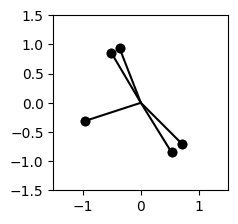

In [10]:
plot_features_in_2d(
    W_normed.unsqueeze(0),  # shape [instances=1 d_hidden=2 features=5]
)

In [11]:
device = (
    t.device("cuda") if t.cuda.is_available()
    else t.device("mps") if t.backends.mps.is_available() 
    else t.device("cpu")
)

def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class ToyModelConfig:
    # We optimize n_inst models in a single training loop to let us sweep over sparsity or importance
    # curves efficiently. The number of instances `n_inst` is like a batch dimension,
    # but one which is built into our training setup. 
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "normal"] = "unif"


class ToyModel(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    # Our linear map (for a single instance) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: ToyModelConfig,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(ToyModel, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_inst, cfg.n_features))
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)

    def forward(
        self,
        features: Float[Tensor, "... inst feats"],
    ) -> Float[Tensor, "... inst feats"]:
        """
        Performs a single forward pass. For a single instance, this is given by:
            x -> ReLU(W.T @ W @ x + b_final)
        """
        h = einops.einsum(features, self.W, "... inst feats, inst hidden feats -> ... inst hidden")
        out = einops.einsum(h, self.W, "... inst hidden, inst hidden feats -> ... inst feats")
        return F.relu(out + self.b_final)

    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst feats"]:
        """
        Generates a batch of data of shape (batch_size, n_instances, n_features).
        """
        batch_shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
        feat_mag = t.rand(batch_shape, device=self.W.device)
        feat_seeds = t.rand(batch_shape, device=self.W.device)
        return t.where(feat_seeds <= self.feature_probability, feat_mag, 0.0)

    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss for a given batch (as a scalar tensor), using this loss described in the
        Toy Models of Superposition paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `self.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        """
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, "batch inst feats -> inst", "mean").sum()
        return loss

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 5_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)

In [12]:
cfg = ToyModelConfig(n_inst=8, n_features=5, d_hidden=2)

# importance varies within features for each instance
importance = 0.9 ** t.arange(cfg.n_features)

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = 50 ** -t.linspace(0, 1, cfg.n_inst)

line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)
line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize()

  0%|          | 0/5000 [00:00<?, ?it/s]

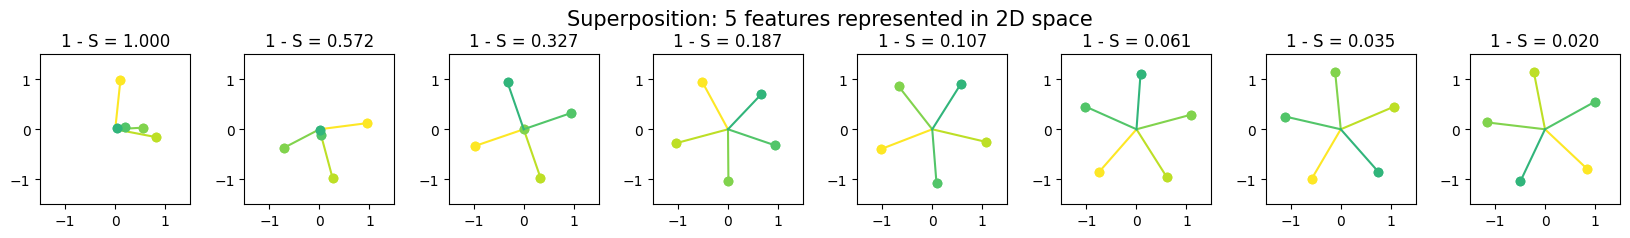

In [13]:
plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)